# Convolutional Neural Networks

In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import torch.nn as nn
from torchvision.models.video import r3d_18
import nibabel as nib
import os
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage import zoom
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [17]:
SHAPE = (128, 160, 128)

## Carregar e tratar dados

In [18]:
data = np.load('dataset_t1c_to_t2w.npz')
X = data['X']
Y = data['Y']

print(X.shape, Y.shape)

(190, 128, 160, 128) (190, 128, 160, 128)


In [19]:
# Adicionar dimensão de canal
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]

In [20]:
# Normalizar
X = X / np.max(X)
Y = Y / np.max(Y)

In [21]:
class MRIDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Transpor para CxDxHxW (PyTorch espera canal primeiro)
        x = torch.tensor(self.X[idx]).permute(3,0,1,2)
        y = torch.tensor(self.Y[idx]).permute(3,0,1,2)
        return x, y

train_dataset = MRIDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

### Processar teste

In [22]:
class MRIDatasetFolder(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.pairs = []

        # Procurar arquivos T1C e T2F (ou T2W) em todas as subpastas
        t1_files = sorted(glob.glob(os.path.join(folder_path, "**/*t1c.nii.gz"), recursive=True))
        t2_files = sorted(glob.glob(os.path.join(folder_path, "**/*t2f.nii.gz"), recursive=True))

        # Fazer correspondência por paciente
        for t1_path in t1_files:
            patient_id = os.path.basename(t1_path).split("-t1c")[0]
            match = [t2 for t2 in t2_files if patient_id in t2]
            if match:
                self.pairs.append((t1_path, match[0]))

        print(f"✅ Encontrados {len(self.pairs)} pares T1C-T2F em {folder_path}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        t1_path, t2_path = self.pairs[idx]

        x = nib.load(t1_path).get_fdata().astype(np.float32)
        y = nib.load(t2_path).get_fdata().astype(np.float32)

        # Normalização simples
        x = x / np.max(x) if np.max(x) > 0 else x
        y = y / np.max(y) if np.max(y) > 0 else y

        factors = [n / s for n, s in zip(SHAPE, x.shape)]
        x = zoom(x, factors, order=1)
        factors = [n / s for n, s in zip(SHAPE, y.shape)]
        y = zoom(y, factors, order=1)

        # Adicionar canal
        x = torch.tensor(x[np.newaxis, ...])
        y = torch.tensor(y[np.newaxis, ...])

        return x, y
    
val_dataset = MRIDatasetFolder("datasets/brats/validation_data")
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(val_dataset)

✅ Encontrados 188 pares T1C-T2F em datasets/brats/validation_data


188

## Analisando shapes

In [23]:
x, y = val_dataset[0]
print("X shape:", x.shape)
print("Y shape:", y.shape)

X shape: torch.Size([1, 128, 160, 128])
Y shape: torch.Size([1, 128, 160, 128])


In [24]:
x, y = train_dataset[0]
print("X shape:", x.shape)
print("Y shape:", y.shape)


X shape: torch.Size([1, 128, 160, 128])
Y shape: torch.Size([1, 128, 160, 128])


## Aplicar CNN

In [ ]:
def resnet_encoder(pretrained=True):
    model = r3d_18(pretrained=pretrained)

    # Remove camadas pooling e fully connected
    model.avgpool = nn.Identity()
    model.fc = nn.Identity()

    # Remove maxpool 
    model.stem[3] = nn.Identity() # 4 é maxpool mesmo?

    # Ajustar todos os strides para 1 (inicialmente são 2)
    conv1 = model.stem[0]
    model.stem[0] = nn.Conv3d(
        conv1.in_channels, conv1.out_channels,
        kernel_size=conv1.kernel_size,
        stride=(1,1,1),
        padding=conv1.padding,
        bias=False
    )

    def fix_strides(layer):
        for block in layer:
            block.conv1.stride = (1,1,1)
            if block.downsample is not None:
                if isinstance(block.downsample[0], nn.Conv3d):
                    block.downsample[0].stride = (1, 1, 1)
        
    fix_strides(model.layer1)
    fix_strides(model.layer2)   
    fix_strides(model.layer3)
    fix_strides(model.layer4)

    return model

In [26]:
class Decoder3D(nn.Module):
    def __init__(self, in_channels=512, out_channels=1):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose3d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, out_channels, kernel_size=3, padding=1)
        )

def forward(self, x):
    return self.decoder(x)

In [27]:
class ResNet3D_EncoderDecoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, pretrained=True):
        super().__init__()

        # carregar encoder modificado
        self.encoder = resnet_encoder(pretrained=pretrained)

        # adaptar primeira convolução para 1 canal (MRI costuma ser 1 canal)
        old_conv = self.encoder.stem[0]
        self.encoder.stem[0] = nn.Conv3d(
            in_channels,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        # decoder
        self.decoder = Decoder3D(in_channels=512, out_channels=out_channels)

    def forward(self, x):
        x = self.encoder(x)   # encoder ResNet3D modificado
        x = self.decoder(x)   # decoder volumétrico
        return x

## Treinando

In [28]:
torch.cuda.empty_cache()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


import pytorch_msssim

criterion = lambda pred, target: 1 - pytorch_msssim.ssim(pred, target, data_range=1.0)


%pip install pytorch-msssim

from pytorch_msssim import ssim  

mse_loss = nn.MSELoss()

def combined_loss(pred, target):
    mse = mse_loss(pred, target)
    ssim_val = ssim(pred, target, data_range=1.0)   SSIM ∈ [0,1]
    total_loss = 0.8 * mse + 0.2 * (1 - ssim_val)
    return total_loss


no loop de treino:
loss = combined_loss(outputs, targets)

In [30]:
model = ResNet3D_EncoderDecoder(
    in_channels=1,
    out_channels=1,
    pretrained=True
).to(device)

criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\Alicia\VSCode\MRI\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alicia\VSCode\MRI\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to C:\Users\Alicia/.cache\torch\hub\checkpoints\r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:02<00:00, 56.0MB/s] 


IndexError: index 4 is out of range

### Comparação Critérios
No MSE, diferenças grandes tem peso muito maior que diferenças pequenas. Por isso, a rede prefere prever a média quando há incertezas. Se uma possibilidade para um voxel é [0,1] e a rede não tem certeza, minimiza para y = 0.5, suavizando previsões e deixando uma aparência borrada.

O L1Loss, por vez, penaliza diferenças lineares, não quadráticas, ou seja, diferenças grades não denominam a perda. Assim, ele mantém bordas mais nítidas.


In [ ]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad() # zera gradientes anteriores
        outputs = model(x_batch) # foward pass
        loss = criterion(outputs, y_batch) # calcula o erro
        loss.backward() # backpropagation
        optimizer.step() # atualiza pesos

        train_loss += loss.item() * x_batch.size(0)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/3, Train Loss: 0.05783
Epoch 2/3, Train Loss: 0.03761


KeyboardInterrupt: 

## Avaliar com MAE e MSE

In [ ]:
model.eval()
val_loss = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        outputs = model(x_batch)
        loss = nn.L1Loss()(outputs, y_batch)  # nn.L1Loss() para MAE
        val_loss += loss.item() * x_batch.size(0)

val_loss /= len(val_loader.dataset)
print(f"Validation Loss (MAE): {val_loss:.5f}")

Validation Loss (MAE): 0.07836


In [ ]:
model.eval()
val_loss = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        outputs = model(x_batch)
        loss = nn.MSELoss()(outputs, y_batch)
        val_loss += loss.item() * x_batch.size(0)

val_loss /= len(val_loader.dataset)
print(f"Validation Loss (MSE): {val_loss:.5f}")

## Visualizar um específico

In [ ]:
model.eval()

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_pred = model(x_batch)

        break  # pegar apenas o primeiro batch para visualização

In [ ]:
x_np = x_batch[0,0].cpu().numpy()
y_true_np = y_batch[0,0].cpu().numpy()
y_pred_np = y_pred[0,0].cpu().numpy()

In [ ]:
def normalize_for_plot(vol):
    vol = vol - vol.min()
    vol = vol / (vol.max() + 1e-8)
    return vol

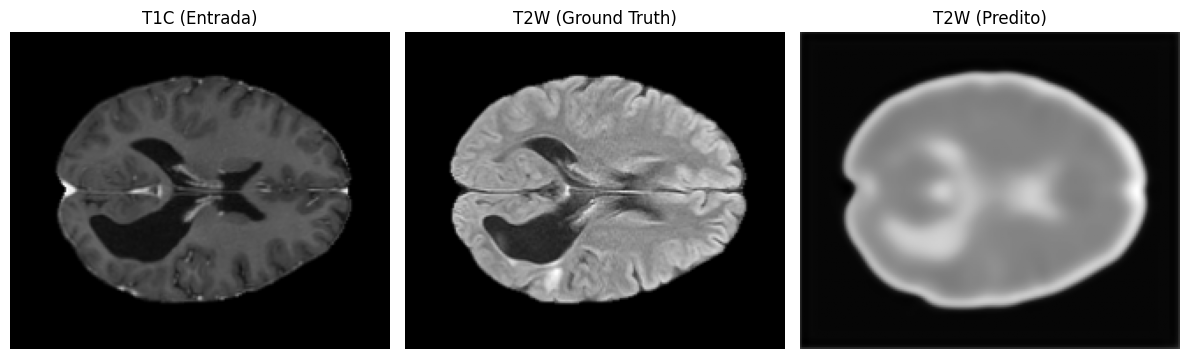

In [ ]:
# slice central
slice_idx = x_np.shape[2] // 2 

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(normalize_for_plot(x_np)[:,:,slice_idx], cmap='gray')
plt.title("T1C (Entrada)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(normalize_for_plot(y_true_np)[:,:,slice_idx], cmap='gray')
plt.title("T2W (Ground Truth)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(normalize_for_plot(y_pred_np)[:,:,slice_idx], cmap='gray')
plt.title("T2W (Predito)")
plt.axis('off')

plt.tight_layout()
plt.show()

### Métricas quantitativas
* SSIM mede similaridade estrutural (≈1 é ótimo).
* PSNR mede relação sinal/ruído (quanto maior, melhor).

In [ ]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

ssim_val = ssim(y_true_np, y_pred_np, data_range=1.0)
psnr_val = psnr(y_true_np, y_pred_np, data_range=1.0)

print(f"SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB")

SSIM: 0.1011, PSNR: 16.71 dB


* SSIM: 0.7407, PSNR: 14.30 dB
* SSIM: 0.1802, PSNR: 18.81 dB